**Setting up the Model**

In [88]:
!pip install tqdm

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from collections import Counter

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categoric = list(df.dtypes[df.dtypes == 'object'].index)

for c in categoric:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [3]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [4]:
df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [5]:
numeric = ['tenure', 'monthlycharges', 'totalcharges']

categoric = ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categoric + numeric].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [7]:
val_dict = df_val[categoric + numeric].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_dec = (y_pred >= 0.5)
(y_val == churn_dec).mean()

np.float64(0.8034066713981547)

# 4.2 Accuracy and Dummy Model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baseline

In [8]:
# Checking total len with number of correct prediction
print('Total n: ', len(y_val))
print('Number of correct prediction: ', (y_val == churn_dec).sum())
print('Number of incorrect prediction: ', len(y_val) - (y_val == churn_dec).sum())
print('Model accuracy: ', (y_val == churn_dec).sum() / len(y_val))

Total n:  1409
Number of correct prediction:  1132
Number of incorrect prediction:  277
Model accuracy:  0.8034066713981547


**Using different threshold values**

In [9]:
# Define thresholds values
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [10]:
# Use them to get the best model accuracy
scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.738
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.734
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


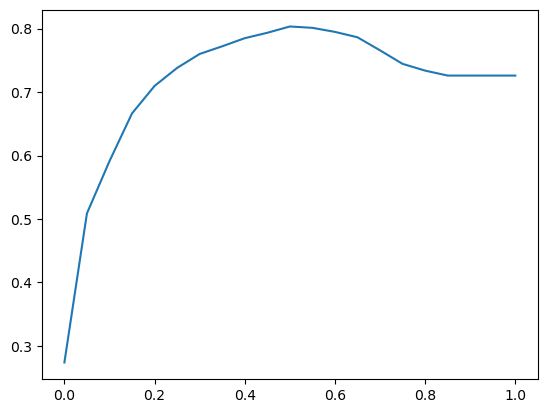

In [11]:
# Plot scores
plt.plot(thresholds, scores)

It seems the best threshold is 0.5

In this particular case, the data is heavily imbalance. The true value of churn is extremely less than the not churning value. This would gave a problem in the future, and this need special treatment.

# 4.3 Confusion Table

- Different types of errors and correct decisions
- Arrange those in a table

In [12]:
# Define a logical mask
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [13]:
# Use threshold 
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [14]:
# Make tp, tn, fp, fn
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [15]:
print('True Positive: ', tp)
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)

True Positive:  210
True Negative:  922
False Positive:  101
False Negative:  176


In [16]:
# Create the table
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [17]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

# 4.4 Precision and Recall

In [18]:
# Another way to express accuracy
(tp + tn) / (tp + tn + fp + fn)

np.float64(0.8034066713981547)

- **Precision** is a metric to measure fraction of positive predictions that are correct. The formula is $\frac{TP}{TP + FP}$
- **Recall** is a metric to measure fraction of correctly identified positive example. The formula is $\frac{TP}{TP + FN}$

In [19]:
# Calculate the precision of the model
p = tp / (tp + fp)
p

np.float64(0.6752411575562701)

In [20]:
# Calculate the recall
r = tp / (tp + fn)
r

np.float64(0.5440414507772021)

 # 4.5 ROC Curve

Let's start with True Positive Rate (TPR) and False Positive Rate (FPR):
- TPR is calculated by $\frac{TP}{TP + FN}$
- FPR is calculated by $\frac{FP}{FP + TN}$

The goal for ROC is to maximize **TPR** and minimize **FPR**

In [21]:
# Checking the value
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print('True Positive Rate: ', tpr)
print('False Positive Rate: ', fpr)

True Positive Rate:  0.5440414507772021
False Positive Rate:  0.09872922776148582


In [22]:
# Define a loop to search for best threshhold value
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [23]:
col = ['threshold', 'true_positive', 'false_positive', 'false_negative', 'true_negative']
df_scores = pd.DataFrame(scores, columns=col)
df_scores[::10]

,threshold,true_positive,false_positive,false_negative,true_negative
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,76,20,310,1003
80,0.8,13,2,373,1021
90,0.9,0,0,386,1023


In [24]:
df_scores['tpr'] = df_scores.true_positive / (df_scores.true_positive + df_scores.false_negative)
df_scores['fpr'] = df_scores.false_positive / (df_scores.false_positive + df_scores.true_negative)

In [25]:
df_scores[::10]

,threshold,true_positive,false_positive,false_negative,true_negative,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,2,373,1021,0.033679,0.001955
90,0.9,0,0,386,1023,0.000000,0.000000


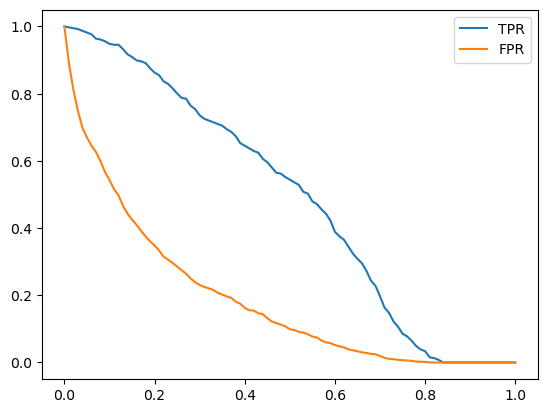

In [26]:
# Plot it 
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

**Testing with random model**

In [27]:
# Create dummy num
np.random.seed(1)

y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02])

In [28]:
# Checking the accuracy
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [29]:
# Define an algorith to create dataframe for tpr_fpr
def tpr_fpr_df(y_val, y_pred):
    # Define a loop to search for best threshhold value
    scores = []
    
    thresholds = np.linspace(0, 1, 101)
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
    
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        scores.append((t, tp, fp, fn, tn))

    col = ['threshold', 'true_positive', 'false_positive', 'false_negative', 'true_negative']
    df_scores = pd.DataFrame(scores, columns=col)

    df_scores['tpr'] = df_scores.true_positive / (df_scores.true_positive + df_scores.false_negative)
    df_scores['fpr'] = df_scores.false_positive / (df_scores.false_positive + df_scores.true_negative)

    return df_scores

In [30]:
# Test the algo
df_rand = tpr_fpr_df(y_val, y_rand)
df_rand[::10]

,threshold,true_positive,false_positive,false_negative,true_negative,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


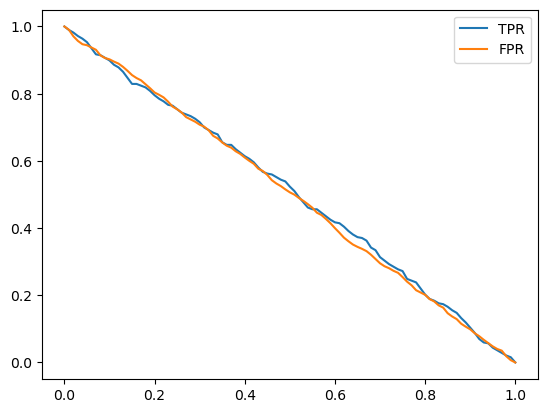

In [31]:
# Plot it 
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

This random model is abysmal. Look at that, it's like a slider in a public pool.

**The case of ideal model**

In [32]:
# Checking the value of negative and positive value
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [33]:
# Create the perfect model
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [34]:
# Create the dummy pred
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [35]:
# Check the acc
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [36]:
# Create the df
df_ideal = tpr_fpr_df(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,true_positive,false_positive,false_negative,true_negative,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


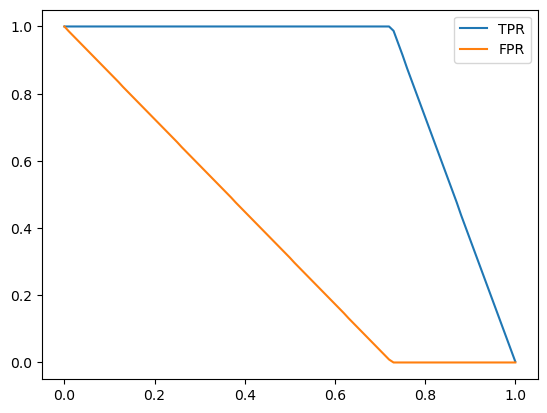

In [37]:
# Plot it 
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

**Putting all together**

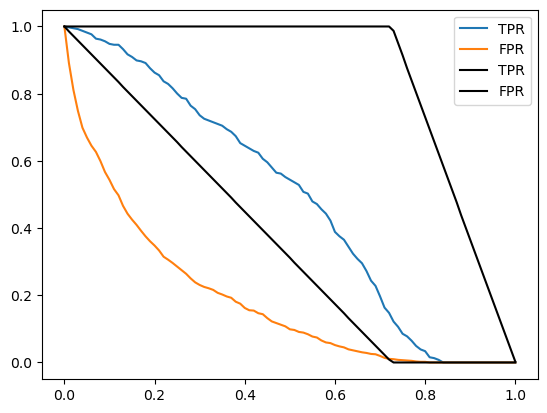

In [38]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')

#plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
#plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR', color='black')
plt.legend()

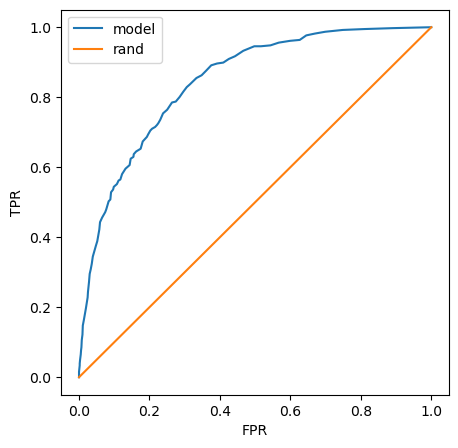

In [39]:
# Look at the tpr and fpr
plt.figure(figsize=(5,5))
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0, 1], [0, 1], label='rand')

#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

**Using Scikit-Learn**

In [40]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

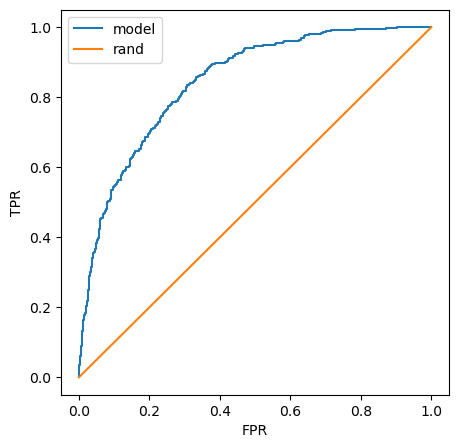

In [41]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='rand')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# 4.6 ROC AUC

- AUC stands for (Area Under the Curve)
- Use this to evaluate and find the best params for your classification model
- The higher value of AUC, the better model it is

So, AUC is probability that randomly selected positive example has higher score than randomly selected negative example.

In [43]:
# Testing the AUC, it's from scikit-learn
auc(fpr, tpr)

0.843863167864505

In [44]:
auc(df_scores.fpr, df_scores.tpr)

0.8437795977491782

In [45]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [47]:
# Using roc_auc_score lib
roc_auc_score(y_val, y_pred)

0.843863167864505

**Implement AUC with code**

In [48]:
# Define neg and pos value
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [53]:
# Randomly select both example
pos_ind = random.randint(0, len(pos) - 1)
neg_ind = random.randint(0, len(neg) - 1)

In [58]:
# Compare random pos and neg example
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)
    
    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.8439

**Implement AUC with NumPy**

In [65]:
n = 50000
np.random.seed(1)

pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

In [66]:
(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.8465)

# 4.7 Cross-Validation

- Evaluate the same model with the different subsets of the data

In [95]:
# Create a function for training
def train(df_train, y_train, C=1.0):
    dicts = df_train[categoric + numeric].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [97]:
dv, model = train(df_train, y_train, C=0.001)

In [84]:
# Create predict function
def predict(df, dv, model):
    dicts = df[categoric + numeric].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [74]:
y_pred = predict(df_val, dv, model)

**Define K-Fold CV**

In [79]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

**Perform K-Fold CV**

In [100]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=n_splits):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

        print(C, np.mean(scores), np.std(scores))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0.001 0.8256234741857745 0.0
0.001 0.8295642781470522 0.003940803961277661
0.001 0.8231251318491889 0.009658079553654796
0.001 0.8223888743073687 0.008460797893946211
0.001 0.8250708998914412 0.009275835581565648


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.01 0.8429088397139515 0.0


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.01 0.8446920291140277 0.0017831894000762682


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.01 0.8395799559937388 0.0073747153254928016
0.01 0.8374758835713736 0.007353310946418358
0.01 0.8399463496044242 0.008226162846771051


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.1 0.8442354640437708 0.0


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.1 0.8449911511054504 0.0007556870616796107


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.1 0.8409312871708421 0.005774573487152646


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.1 0.8392428033265871 0.005793289850838195
0.1 0.8418156288744415 0.0073025674276537365


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5 0.8448359774238368 0.0


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5 0.8450782737734996 0.00024229634966282942


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5 0.8411753345659708 0.005523133826253442
0.5 0.8395597360399095 0.005541591038615485
0.5 0.8419930870654314 0.006946378469752808


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1 0.844596557056621 0.0


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1 0.844890277932363 0.00029372087574203176


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1 0.8410339494196221 0.005458942556172352
1 0.8394656879712203 0.00545237308750244
1 0.8419154953739956 0.006912953281414879


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5 0.8446358062971482 0.0


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5 0.8449036947655784 0.00026788846843023295


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5 0.8411151396102584 0.005362288984269109


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5 0.8395255813816083 0.005398675156917581
5 0.8419673321631136 0.006867688277423512


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


10 0.8444513348666703 0.0


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


10 0.8448011127385928 0.0003497778719224187


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


10 0.8409638029000478 0.005434285291901587
10 0.8394290658029696 0.005405075979741432
10 0.8419050235312715 0.0069205016990659335


/opt/conda/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [92]:
# Compute mean and std of score
np.mean(scores), np.std(scores)

(np.float64(0.8410938402906643), np.float64(0.011987864915953607))

**Train the final model**

In [101]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8583463334308341